In [1]:
%cd /home/ltchen/gnnpp
import sys
import json
import copy
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
import shap
import matplotlib.pyplot as plt
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *

/home/ltchen/gnnpp


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Shuffle Features for g1 while sleeping:

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()

leadtimes = ["24h", "72h", "120h"]
for leadtime in leadtimes:
    data_type = "f"
    graph_name = "g1"
    drn = False

    JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
    with open(JSONPATH, "r") as f:
        # print(f"[INFO] Loading {JSONPATH}")
        args_dict = json.load(f)
    config = args_dict
    # print(f"json: {JSONPATH}")
    print(f"save: {SAVEPATH}")
    # print(f"result: {RESULTPATH}")

    g_train_rf, g_valid_rf, g_test_rf, g_test_f = get_train_valid_graph_data(leadtime=leadtime, graph_name=graph_name)

    g1_train_loader = DataLoader(g_train_rf, batch_size=config['batch_size'], shuffle=True)
    g1_valid_loader = DataLoader(g_valid_rf, batch_size=config['batch_size'], shuffle=True)
    g1_test_f_loader = DataLoader(g_test_f, batch_size=config['batch_size'], shuffle=False)
    g1_test_rf_loader = DataLoader(g_test_rf, batch_size=config['batch_size'], shuffle=False)

    train_loader = g1_train_loader
    valid_loader = g1_valid_loader
    test_f_loader = g1_test_f_loader
    test_rf_loader = g1_test_rf_loader
    test_loader = [test_f_loader, test_rf_loader]

    dataframes = load_dataframes(leadtime=leadtime)
    dataframes = summary_statistics(dataframes)

    if data_type == "f":
        graphs_test = g_test_f
    if data_type == "rf":
        graphs_test = g_test_rf

    emb_dim = 20
    in_channels = g_train_rf[0].x.shape[1] + emb_dim - 1
    edge_dim = g_train_rf[0].num_edge_features
    num_nodes = g_train_rf[0].num_nodes


    # Versuch: direkt dataframe erstellen und befüllen
    all_feature_names, grouped_list = get_feature_list()
    times_to_shuff = 3

    targets = dataframes[f"test_{data_type}"][1]
    targets = torch.tensor(targets.t2m.values) - 273.15
    crps_shuff_cols = ['Feature'] + [f"CRPS_{shuffle_id}" for shuffle_id in range(0, times_to_shuff)]
    df = pd.DataFrame(columns=crps_shuff_cols)

    # für jede feature group: 3x shufflen und bei jedem shuffle zsmgefassten CRPS aus 10 ensembles
    for f_list in grouped_list:
        # for each grouped feature (34 different groups) ########################################
        feature_idx = [i for i, value in enumerate(all_feature_names) if value in f_list]
        xs = [g.x for g in graphs_test]  # g.x.shape (120, 65)
        xs = torch.stack(xs)  # shape: (730, 120, 65)
        feature_crps_scores = []        # shuffle the features
        for shuffle_id in range(0, times_to_shuff):
            xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
            graphs_test_shuffled = []

            for graph, shuffled_feature in zip(graphs_test, xs_shuffled):
                graph_copy = copy.deepcopy(graph)
                graph_copy.x = shuffled_feature
                graphs_test_shuffled.append(graph_copy)  # len 732

            bs = 1
            shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)
            preds_list = []

            # run all 10 models for each shuffle ##################################################

            for run_no in range(0, 10):
                # run_no = 0
                model = load_gnn_model(os.path.join(SAVEPATH, f"{graph_name}_{leadtime}_train_run{run_no}.ckpt"), num_nodes,
                                       emb_dim, edge_dim, in_channels, config)
                batch = next(iter(train_loader))
                batch = batch.to("cuda")
                model.to("cuda")
                model.forward(batch)
                trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=False)
                preds = trainer.predict(model=model, dataloaders=[shuffled_test_loader])
                # print(f"\033[91m len(preds):{len(preds)} \033[0m")
                preds = torch.cat(preds, dim=0)
                # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
                preds_list.append(preds)

            ###
            # targets = dataframes[f"test_{data_type}"][1]
            # targets = torch.tensor(targets.t2m.values) - 273.15
            # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
            stacked = torch.stack(preds_list)
            final_preds = torch.mean(stacked, dim=0)

            res = model.loss_fn.crps(final_preds, targets)  # mean
            score = res.item()  # summarized CRPS (of 10 ens) for graph with specific feature being shuffled
            # print(f"score: {score}")
            # print(f"res: {res}")
            # print(f"f_list: {f_list}")

            # feature_crps_scores[f"{f_list}"].append(score) # create a list of the crps values
            feature_crps_scores.append(score)  # as a list
            # pprint(feature_crps_scores)
            # rows.append({
            #     'Feature': f_list,
            #     'CRPS': score,
            # })
        # print(len(rows))
        # add to dataframe of feature
        if isinstance(f_list, list):
            f = f_list[0].split("_")[0]
        else:
            f = f_list.split("_")[1]
        # print(f)
        data = [f] + feature_crps_scores
        new_df = pd.DataFrame([data], columns=crps_shuff_cols)
        df = pd.concat([df, new_df], ignore_index=True)
        # print(df)

    # stored_pi = pd.DataFrame(rows)
    # print(stored_pi)
    # df_crps = pd.DataFrame([
    #     {'Feature': k, 'CRPS_values': v, 'CRPS_mean': sum(v)/len(v)}
    #     for k, v in feature_crps_scores.items()
    # ])
    shuffle_list = [f"CRPS_{shuffle_id}" for shuffle_id in range(0, times_to_shuff)]
    df['CRPS_mean'] = df[shuffle_list].mean(axis=1)
    df['CRPS_std'] = df[shuffle_list].std(axis=1)
    df.to_csv(os.path.join(RESULTPATH, f'permutation_importance_{data_type}.csv'), index=False)
    print('###########################################################################')
    print(leadtime)
    print(df)

save: /home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/models
[INFO] Loading precomputed graph data on g1...


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float

###########################################################################
24h
      Feature    CRPS_0    CRPS_1    CRPS_2  CRPS_mean  CRPS_std
0          id  0.927923  0.926762  0.927813   0.927499  0.000641
1   orography  0.627683  0.628202  0.628481   0.628122  0.000405
2    altitude  0.671322  0.670877  0.671997   0.671399  0.000564
3    latitude  0.663618  0.663319  0.662996   0.663311  0.000311
4   longitude  0.624243  0.624231  0.623726   0.624067  0.000295
5        cape  0.620179  0.619130  0.621821   0.620377  0.001357
6          sd  0.625009  0.624153  0.624663   0.624608  0.000430
7        stl1  0.855180  0.856713  0.857496   0.856463  0.001178
8       swvl1  0.655427  0.657539  0.657042   0.656669  0.001104
9         t2m  2.375247  2.286911  2.326635   2.329598  0.044242
10        tcc  0.633552  0.632791  0.633361   0.633235  0.000396
11        tcw  0.672229  0.677380  0.673916   0.674508  0.002626
12       tcwv  0.689241  0.687688  0.686088   0.687673  0.001576
13        

/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used:

###########################################################################
72h
      Feature    CRPS_0    CRPS_1    CRPS_2  CRPS_mean  CRPS_std
0          id  1.063331  1.064424  1.067034   1.064930  0.001903
1   orography  0.787924  0.788039  0.787751   0.787905  0.000145
2    altitude  0.820400  0.819340  0.819810   0.819850  0.000532
3    latitude  0.809094  0.808532  0.808713   0.808780  0.000287
4   longitude  0.792413  0.792765  0.792141   0.792439  0.000313
5        cape  0.782541  0.783352  0.783830   0.783241  0.000652
6          sd  0.795775  0.796351  0.797506   0.796544  0.000882
7        stl1  1.055495  1.094806  1.104918   1.085073  0.026110
8       swvl1  0.824653  0.821308  0.821549   0.822503  0.001865
9         t2m  1.543908  1.576132  1.578821   1.566287  0.019428
10        tcc  0.798087  0.798447  0.794723   0.797086  0.002054
11        tcw  0.800491  0.798780  0.802658   0.800643  0.001944
12       tcwv  0.826773  0.829314  0.827988   0.828025  0.001271
13        

/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used:

###########################################################################
120h
      Feature    CRPS_0    CRPS_1    CRPS_2  CRPS_mean  CRPS_std
0          id  1.280537  1.278899  1.278127   1.279187  0.001231
1   orography  1.103949  1.104958  1.104102   1.104336  0.000544
2    altitude  1.132593  1.132691  1.132619   1.132634  0.000051
3    latitude  1.111632  1.110156  1.110817   1.110868  0.000740
4   longitude  1.101692  1.101445  1.101082   1.101407  0.000307
5        cape  1.089985  1.096995  1.093733   1.093571  0.003508
6          sd  1.110382  1.111977  1.110393   1.110917  0.000918
7        stl1  1.461046  1.416036  1.494809   1.457297  0.039520
8       swvl1  1.121614  1.123824  1.127151   1.124196  0.002787
9         t2m  1.629814  1.618597  1.547614   1.598675  0.044574
10        tcc  1.098119  1.097666  1.099103   1.098296  0.000735
11        tcw  1.109796  1.107378  1.109142   1.108772  0.001251
12       tcwv  1.108825  1.110854  1.110408   1.110029  0.001066
13       

In [ ]:
# plot PI!

# Actual shuffle

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()
#DIRECTORY

leadtime = "120h"
data_type = "f"
graph_name = "g1"
drn = False

JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict
print(f"json: {JSONPATH}")
print(f"save: {SAVEPATH}")
print(f"result: {RESULTPATH}")

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_120h/g1_120h/params.json
json: /home/ltchen/gnnpp/leas_trained_models/sum_stats_120h/g1_120h/params.json
save: /home/ltchen/gnnpp/leas_trained_models/sum_stats_120h/g1_120h/models
result: /home/ltchen/gnnpp/leas_trained_models/sum_stats_120h/g1_120h/


# Permutation Importance for GNN

In [3]:
g_train_rf, g_valid_rf, g_test_rf, g_test_f = get_train_valid_graph_data(leadtime=leadtime, graph_name=graph_name)

g1_train_loader = DataLoader(g_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(g_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(g_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(g_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

dataframes = load_dataframes(leadtime=leadtime)
dataframes = summary_statistics(dataframes)

if data_type == "f":
    graphs_test = g_test_f
if data_type == "rf":
    graphs_test = g_test_rf

emb_dim = 20
in_channels = g_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = g_train_rf[0].num_edge_features
num_nodes = g_train_rf[0].num_nodes

[INFO] Loading precomputed graph data on g1...


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.
[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [4]:
all_feature_names, grouped_list = get_feature_list()
times_to_shuff = 3
feature_crps_scores = defaultdict(list)
targets = dataframes[f"test_{data_type}"][1]
targets = torch.tensor(targets.t2m.values) - 273.15

df = pd.DataFrame(columns=['Feature'])

# für jede feature group: 3x shufflen und bei jedem shuffle zsmgefassten CRPS aus 10 ensembles
for f_list in grouped_list:
    # for each grouped feature (34 different groups) ########################################
    feature_idx = [i for i, value in enumerate(all_feature_names) if value in f_list]
    xs = [g.x for g in graphs_test] # g.x.shape (120, 65)
    xs = torch.stack(xs) # shape: (730, 120, 65)

    # shuffle the features
    for shuffle_id in range(0, times_to_shuff):
        xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
        graphs_test_shuffled = []

        for graph, shuffled_feature in zip(graphs_test, xs_shuffled):
            graph_copy = copy.deepcopy(graph)
            graph_copy.x = shuffled_feature
            graphs_test_shuffled.append(graph_copy) # len 732

        bs = 1
        shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)
        preds_list = []

        # run all 10 models for each shuffle ##################################################

        for run_no in range(0, 10):
            # run_no = 0
            model = load_gnn_model(os.path.join(SAVEPATH,f"{graph_name}_{leadtime}_train_run{run_no}.ckpt"), num_nodes, emb_dim, edge_dim, in_channels, config)
            batch = next(iter(train_loader))
            batch = batch.to("cuda")
            model.to("cuda")
            model.forward(batch)
            trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=False)
            preds = trainer.predict(model=model, dataloaders=[shuffled_test_loader])
            # print(f"\033[91m len(preds):{len(preds)} \033[0m")
            preds = torch.cat(preds, dim=0)
            # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
            preds_list.append(preds)

        ###
        # targets = dataframes[f"test_{data_type}"][1]
        # targets = torch.tensor(targets.t2m.values) - 273.15
        # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
        stacked = torch.stack(preds_list)
        final_preds = torch.mean(stacked, dim=0)

        res = model.loss_fn.crps(final_preds, targets) # mean
        score = res.item()                  # summarized CRPS (of 10 ens) for graph with specific feature being shuffled
        # print(f"score: {score}")
        # print(f"res: {res}")
        # print(f"f_list: {f_list}")

        feature_crps_scores[f"{f_list}"].append(score)
        # pprint(feature_crps_scores)
        # rows.append({
        #     'Feature': f_list,
        #     'CRPS': score,
        # })
    # print(len(rows))
# stored_pi = pd.DataFrame(rows)
# print(stored_pi)
df_crps = pd.DataFrame([
    {'Feature': k, 'CRPS_values': v, 'CRPS_mean': sum(v)/len(v)}
    for k, v in feature_crps_scores.items()
])
# 40 min

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float

In [5]:
columns = []
columns += [f'CRPS_shuff{i}' for i in range(times_to_shuff)]
crps_values_to_cols = pd.DataFrame(df_crps['CRPS_values'].tolist(), columns=columns)
df_combined = pd.concat([df_crps.drop(columns=['CRPS_values']), crps_values_to_cols], axis=1)
df_combined.to_csv(os.path.join(RESULTPATH, f'shuff{times_to_shuff}_permutation_importance_{data_type}.csv'), index=False)
df_combined

,Feature,CRPS_mean,CRPS_shuff0,CRPS_shuff1,CRPS_shuff2
0,['station_id'],1.066160,1.067170,1.064453,1.066858
1,['model_orography'],0.788056,0.787981,0.787957,0.788230
2,['station_altitude'],0.819696,0.820944,0.819250,0.818893
3,['station_latitude'],0.808148,0.808065,0.807595,0.808784
4,['station_longitude'],0.791936,0.792092,0.791946,0.791769
5,"['cape_mean', 'cape_std']",0.782471,0.782168,0.783037,0.782207
6,"['sd_mean', 'sd_std']",0.796984,0.794312,0.798597,0.798043
7,"['stl1_mean', 'stl1_std']",1.092667,1.109781,1.078938,1.089282
8,"['swvl1_mean', 'swvl1_std']",0.819398,0.819217,0.819169,0.819809
9,"['t2m_mean', 't2m_std']",1.574472,1.563023,1.560058,1.600335


In [ ]:
# Versuch: direkt dataframe erstellen und befüllen
all_feature_names, grouped_list = get_feature_list()
times_to_shuff = 3

targets = dataframes[f"test_{data_type}"][1]
targets = torch.tensor(targets.t2m.values) - 273.15
crps_shuff_cols = ['Feature'] + [f"CRPS_{shuffle_id}" for shuffle_id in range(0, times_to_shuff)]
df = pd.DataFrame(columns=crps_shuff_cols)

# für jede feature group: 3x shufflen und bei jedem shuffle zsmgefassten CRPS aus 10 ensembles
for f_list in grouped_list:
    # for each grouped feature (34 different groups) ########################################
    feature_idx = [i for i, value in enumerate(all_feature_names) if value in f_list]
    xs = [g.x for g in graphs_test]  # g.x.shape (120, 65)
    xs = torch.stack(xs)  # shape: (730, 120, 65)
    feature_crps_scores = []
    # shuffle the features
    for shuffle_id in range(0, times_to_shuff):
        xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
        graphs_test_shuffled = []

        for graph, shuffled_feature in zip(graphs_test, xs_shuffled):
            graph_copy = copy.deepcopy(graph)
            graph_copy.x = shuffled_feature
            graphs_test_shuffled.append(graph_copy)  # len 732

        bs = 1
        shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)
        preds_list = []

        # run all 10 models for each shuffle ##################################################

        for run_no in range(0, 10):
            # run_no = 0
            model = load_gnn_model(os.path.join(SAVEPATH, f"{graph_name}_{leadtime}_train_run{run_no}.ckpt"), num_nodes,
                                   emb_dim, edge_dim, in_channels, config)
            batch = next(iter(train_loader))
            batch = batch.to("cuda")
            model.to("cuda")
            model.forward(batch)
            trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=False)
            preds = trainer.predict(model=model, dataloaders=[shuffled_test_loader])
            # print(f"\033[91m len(preds):{len(preds)} \033[0m")
            preds = torch.cat(preds, dim=0)
            # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
            preds_list.append(preds)

        ###
        # targets = dataframes[f"test_{data_type}"][1]
        # targets = torch.tensor(targets.t2m.values) - 273.15
        # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
        stacked = torch.stack(preds_list)
        final_preds = torch.mean(stacked, dim=0)

        res = model.loss_fn.crps(final_preds, targets)  # mean
        score = res.item()  # summarized CRPS (of 10 ens) for graph with specific feature being shuffled
        # print(f"score: {score}")
        # print(f"res: {res}")
        # print(f"f_list: {f_list}")

        # feature_crps_scores[f"{f_list}"].append(score) # create a list of the crps values
        feature_crps_scores.append(score)  # as a list
        # pprint(feature_crps_scores)
        # rows.append({
        #     'Feature': f_list,
        #     'CRPS': score,
        # })
    # print(len(rows))
    # add to dataframe of feature
    data = [f_list] + feature_crps_scores
    print(data)
    print(len(data))
    print(type(data))
    print(crps_shuff_cols)
    new_df = pd.DataFrame([data], columns=crps_shuff_cols)
    df = pd.concat([df, new_df], ignore_index=True)
    print(df)

# stored_pi = pd.DataFrame(rows)
# print(stored_pi)
# df_crps = pd.DataFrame([
#     {'Feature': k, 'CRPS_values': v, 'CRPS_mean': sum(v)/len(v)}
#     for k, v in feature_crps_scores.items()
# ])
df
shuffle_list = [f"CRPS_{shuffle_id}" for shuffle_id in range(0, times_to_shuff)]
df['CRPS_mean'] = df[shuffle_list].mean(axis=1)
df['CRPS_std'] = df[shuffle_list].std(axis=1)
df.to_csv(os.path.join(RESULTPATH, f'permutation_importance_{data_type}.csv'), index=False)

0.7811844855375837


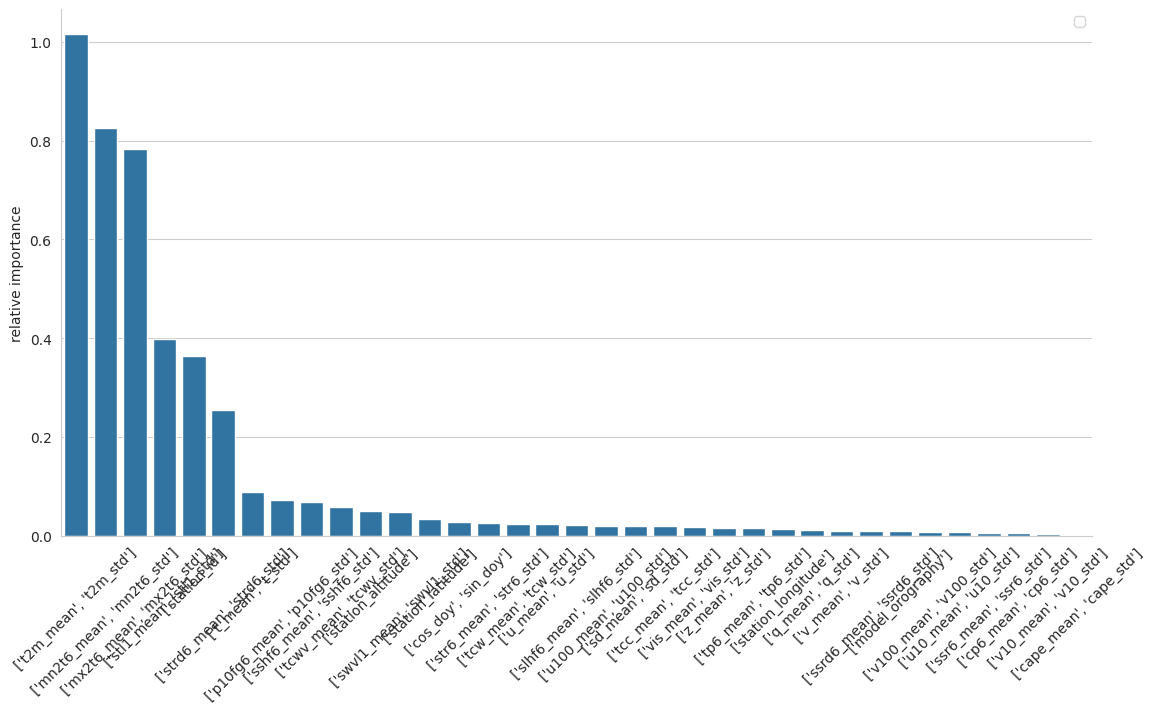

In [8]:
import seaborn as sns
sns.set_style("whitegrid")
# c = [get_color(lead_time)(0.6) for lead_time in ["24h", "72h", "120h"]]
sorted_pi = df_combined.sort_values(by='CRPS_mean', ascending=False)
crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])
print(crps_value)
sorted_pi['Relative'] = (sorted_pi['CRPS_mean'] - crps_value) / crps_value
g = sns.catplot(data=sorted_pi, kind="bar",
                x='Feature', y="Relative", errorbar="CRPS_std", height=6, aspect=2,
                legend_out=None)
g.set_axis_labels("", "relative importance")
g.legend.set_title("")

g.set(ylim=(0, None))

# Rotate x-axis labels by 45 degrees
g.set_xticklabels(rotation=45)

In [ ]:
sorted_pi = df_combined.sort_values(by='CRPS_mean', ascending=False)
# sorted_pi['Feature'] = sorted_pi['Feature'].apply(lambda x: '-'.join(x) if isinstance(x, list) else str(x))
crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])
print(crps_value)
sorted_pi['Relative'] = (sorted_pi['CRPS_mean'] - crps_value) / crps_value
plt.figure(figsize=(10, 6))
plt.bar(sorted_pi['Feature'], sorted_pi['Relative'])

plt.xlabel('Feature')
plt.ylabel('CRPS Score')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x labels so they don't overlap
plt.grid(axis='y')  # Horizontal grid lines
plt.tight_layout()  # Fit everything nicely
plt.show()

# Permutation Importane for DRN

# Previous

In [38]:
graphs4_train_rf, tests4 = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['valid'], dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["dist2", "dist3"], edges=[("dist2", 0.003), ("dist3", 0.0073)], sum_stats = True)
graphs4_valid_rf, graphs4_test_rf, graphs4_test_f = tests4

g4_train_loader = DataLoader(graphs4_train_rf, batch_size=config['batch_size'], shuffle=True)
g4_valid_loader = DataLoader(graphs4_valid_rf, batch_size=config['batch_size'], shuffle=True)
g4_test_f_loader = DataLoader(graphs4_test_f, batch_size=config['batch_size'], shuffle=False)
g4_test_rf_loader = DataLoader(graphs4_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g4_train_loader
valid_loader = g4_valid_loader
test_f_loader = g4_test_f_loader
test_rf_loader = g4_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = graphs4_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = graphs4_train_rf[0].num_edge_features
num_nodes = graphs4_train_rf[0].num_nodes
# max_epochs = max_epoch_list[graph_name]

[INFO] Normalizing features...
fit_transform
transform 1
transform 2
transform 3
[INFO] Loading distances from file...
[INFO] Loading distances from file...


100%|██████████| 2612/2612 [00:12<00:00, 216.67it/s]


[INFO] Loading distances from file...
[INFO] Loading distances from file...


100%|██████████| 836/836 [00:03<00:00, 270.75it/s]


[INFO] Loading distances from file...
[INFO] Loading distances from file...


100%|██████████| 732/732 [00:02<00:00, 269.50it/s]


[INFO] Loading distances from file...
[INFO] Loading distances from file...


100%|██████████| 730/730 [00:03<00:00, 239.92it/s]


In [59]:
# num_nodes
print(graph_name)
print(SAVEPATH)
print(edge_dim)

g1
/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/models
1


## Load model

In [7]:
def load_drn_data(leadtime: str):
    # MODEL = "24h"
    dataframes = load_dataframes(leadtime=leadtime)
    dataframes = summary_statistics(dataframes)
    dataframes.pop("stations")

    # test
    for X, y in dataframes.values():  # wofuer?
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)

    train, valid_test = normalize_features(training_data=dataframes["train"], valid_test_data=[dataframes["test_rf"], dataframes["test_f"]])
    train = drop_nans(train)
    (test_rf, test_f) = valid_test
    test_rf = drop_nans(test_rf)
    test_f = drop_nans(test_f)
    return train, test_rf, test_f

def prepare_g1_data(leadtime: str, graph_name):
    dataframes = load_dataframes(leadtime=leadtime)
    dataframes = summary_statistics(dataframes)
    graphs1_train_rf, tests1 = normalize_features_and_create_graphs1(df_train=dataframes['train'],
                                                                     df_valid_test=[dataframes['valid'], dataframes['test_rf'], dataframes['test_f']],
                                                                     station_df=dataframes['stations'],
                                                                     attributes=["geo"],
                                                                     edges=[("geo", 50)],
                                                                     sum_stats=True)
    graphs1_valid_rf, graphs1_test_rf, graphs1_test_f = tests1
    # os.makedirs('exploration/graphs', exist_ok=True)
    # torch.save(graphs1_train_rf, 'exploration/graphs/train-AgEg50.pt')
    # torch.save(graphs1_valid_rf, 'exploration/graphs/valid-AgEg50.pt')
    # torch.save(graphs1_test_rf, 'exploration/graphs/test_rf-AgEg50.pt')
    # torch.save(graphs3_test_f, 'exploration/graphs/test_f-AgEg50.pt')
    return graphs1_train_rf, graphs1_valid_rf, graphs1_test_rf, graphs1_test_f


In [8]:
def load_gnn_model(path: str, num_nodes, emb_dim, edge_dim, in_channels, config):
    multigraph_model = Multigraph.load_from_checkpoint(
        path,
        num_nodes=num_nodes,
        embedding_dim=emb_dim,
        edge_dim=edge_dim,
        in_channels=in_channels,
        hidden_channels_gnn=config['gnn_hidden'],
        out_channels_gnn=config['gnn_hidden'],
        num_layers_gnn=config['gnn_layers'],
        heads=config['heads'],
        hidden_channels_deepset=config['gnn_hidden'],
        optimizer_class=AdamW,
        optimizer_params=dict(lr=config['lr']),
        )
    multigraph_model.eval()
    return multigraph_model

def load_drn_model(path: str, embed_dim, in_channels, hidden_channels):
    drn_model = DRN.load_from_checkpoint(
                path,
                embedding_dim=embed_dim,
                in_channels=in_channels,
                hidden_channels=hidden_channels,
                optimizer_class=AdamW,
                optimizer_params=dict(lr=lr),
            )
    drn_model.eval()
    return drn_model

In [9]:
def get_feature_list(test_df):
    feature_names = [f for f in test_df.columns.tolist() if f not in ['time', 'number']]
    grouped = []
    i = 0
    while i < len(feature_names):
        if feature_names[i] == 'cos_doy':
            if i + 1 < len(feature_names) and 'sin_doy' in feature_names[i+1]:
                grouped.append([feature_names[i], feature_names[i+1]])
                i += 2
            else:
                grouped.append([feature_names[i]])
                i += 1
        elif i + 1 < len(feature_names) and feature_names[i+1] == feature_names[i].replace('mean', 'std'):
            grouped.append([feature_names[i], feature_names[i+1]])
            i += 2
        else:
            grouped.append([feature_names[i]])
            i += 1
    return feature_names, grouped

In [10]:
graphs_test = graphs1_test_f
data_type = "f"

In [56]:
def s1huffle_features(xs: torch.Tensor, feature_permute_idx: List[int]) -> torch.Tensor:
    """Shuffle a tensor of the shape [T, N, F] first along the T dimension and then along the N dimension

    Args:
        xs (torch.Tensor): [T, N, F]
        feature_permute_idx (List[int]): indices of the features to permute
        (can be used to permute certain features together)

    Returns:
        torch.tensor: the shuffled tensor
    """
    xs_permuted = xs[..., feature_permute_idx]  # [T, N, F] (730, 120, 65)
    T, N, _ = xs_permuted.shape
    torch.manual_seed(0)
    perm_T = torch.randperm(T)  # First permute the features in time, xs_with chosen features permuted
    xs_permuted = xs_permuted[perm_T, ...]
    print(xs_permuted.shape)
    # Then permute the features within each ensemble member
    # Shuffle across N dimension, but do so differently for each time step T
    # summary statistics?
    print(torch.rand((T,N)).shape)
    indices = torch.argsort(torch.rand((T, N)), dim=1).unsqueeze(-1).repeat(1, 1, len(feature_permute_idx)) # (730, 120, len_feat_list)
    # print(indices[:5, :5])
    # print(indices.shape)
    result = torch.gather(xs_permuted, dim=1, index=indices) # don't need this for sum_stats
    # print(result.shape)
    # Replace features with permuted features
    xs[..., feature_permute_idx] = result # don't need this for sum_stats
    # print(xs.shape)
    return xs

In [11]:
# eine spalte shufflen
def shuffle_drn_features(xs, feature_permute_idx):
    xs_permuted = xs[..., feature_permute_idx]  # (86742,)
    print(xs_permuted.shape) # [86742, 1]

    T = xs_permuted.shape[0] # T,
    perm_T = torch.randperm(T)  # permute the features in column across time
    xs_permuted = xs_permuted[perm_T, ...]
    # print(xs_permuted.shape)

    # Replace features with permuted features
    xs[..., feature_permute_idx] = xs_permuted
    return xs

### Permutation importance for GNN

In [25]:
# run again, we had xs_permuted somehow? => but shouldn't make difference
# rows = []
all_feature_names, feature_list = get_feature_list()
times_to_shuff = 3
feature_crps_scores = defaultdict(list)
for f_list in feature_list:
    feature_idx = [i for i, value in enumerate(all_feature_names) if value in f_list]
    xs = [g.x for g in graphs_test] # g.x.shape (120, 65)
    xs = torch.stack(xs) # shape: (730, 120, 65)

    for shuffle_id in range(0, times_to_shuff):
        xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)

        graphs_test_shuffled = []

        for graph, shuffled_feature in zip(graphs_test, xs_shuffled):
            graph_copy = copy.deepcopy(graph)
            graph_copy.x = shuffled_feature
            graphs_test_shuffled.append(graph_copy) # len 732

        bs = 1
        shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)
        preds_list = []
        for run_no in range(0, 10):
            # run_no = 0
            model = load_gnn_model(f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/models/{graph_name}_{leadtime}_train_run{run_no}.ckpt", num_nodes, emb_dim, edge_dim, in_channels, config)
            batch = next(iter(train_loader))
            batch = batch.to("cuda")
            model.to("cuda")
            model.forward(batch)
            trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=False)
            preds = trainer.predict(model=model, dataloaders=[shuffled_test_loader])
            # print(f"\033[91m len(preds):{len(preds)} \033[0m")
            preds = torch.cat(preds, dim=0)
            # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
            preds_list.append(preds)

        ###
        targets = dataframes[f"test_{data_type}"][1]
        targets = torch.tensor(targets.t2m.values) - 273.15
        # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
        stacked = torch.stack(preds_list)
        final_preds = torch.mean(stacked, dim=0)

        res = model.loss_fn.crps(final_preds, targets) # mean
        score = res.item()
        # print(f"score: {score}")
        # print(f"res: {res}")
        # print(f"f_list: {f_list}")

        feature_crps_scores[f"{f_list}"].append(score)
        # pprint(feature_crps_scores)
        # rows.append({
        #     'Feature': f_list,
        #     'CRPS': score,
        # })
    # print(len(rows))
# stored_pi = pd.DataFrame(rows)
# print(stored_pi)
df_crps = pd.DataFrame([
    {'Feature': k, 'CRPS_values': v, 'CRPS_mean': sum(v)/len(v)}
    for k, v in feature_crps_scores.items()
])
# 30 min fuer 3 shuffles

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used:

In [33]:
all_feature_names

['station_id',
 'model_orography',
 'station_altitude',
 'station_latitude',
 'station_longitude',
 'cape_mean',
 'cape_std',
 'sd_mean',
 'sd_std',
 'stl1_mean',
 'stl1_std',
 'swvl1_mean',
 'swvl1_std',
 't2m_mean',
 't2m_std',
 'tcc_mean',
 'tcc_std',
 'tcw_mean',
 'tcw_std',
 'tcwv_mean',
 'tcwv_std',
 'u10_mean',
 'u10_std',
 'u100_mean',
 'u100_std',
 'v10_mean',
 'v10_std',
 'v100_mean',
 'v100_std',
 'vis_mean',
 'vis_std',
 'cp6_mean',
 'cp6_std',
 'mn2t6_mean',
 'mn2t6_std',
 'mx2t6_mean',
 'mx2t6_std',
 'p10fg6_mean',
 'p10fg6_std',
 'slhf6_mean',
 'slhf6_std',
 'sshf6_mean',
 'sshf6_std',
 'ssr6_mean',
 'ssr6_std',
 'ssrd6_mean',
 'ssrd6_std',
 'str6_mean',
 'str6_std',
 'strd6_mean',
 'strd6_std',
 'tp6_mean',
 'tp6_std',
 'z_mean',
 'z_std',
 'q_mean',
 'q_std',
 'u_mean',
 'u_std',
 'v_mean',
 'v_std',
 't_mean',
 't_std',
 'cos_doy',
 'sin_doy']

In [27]:
columns = []
columns += [f'CRPS_shuff{i}' for i in range(times_to_shuff)]
crps_values_to_cols = pd.DataFrame(df_crps['CRPS_values'].tolist(), columns=columns)
df_combined = pd.concat([df_crps.drop(columns=['CRPS_values']), crps_values_to_cols], axis=1)
df_combined

,Feature,CRPS_mean,CRPS_shuff0,CRPS_shuff1,CRPS_shuff2
0,['station_id'],0.928723,0.930432,0.928363,0.927375
1,['model_orography'],0.628064,0.628012,0.628247,0.627932
2,['station_altitude'],0.672051,0.672531,0.671787,0.671835
3,['station_latitude'],0.663248,0.663414,0.663647,0.662682
4,['station_longitude'],0.624118,0.624536,0.623834,0.623983
5,"['cape_mean', 'cape_std']",0.619616,0.619750,0.619518,0.619580
6,"['sd_mean', 'sd_std']",0.624174,0.625227,0.622758,0.624537
7,"['stl1_mean', 'stl1_std']",0.862118,0.858427,0.867837,0.860091
8,"['swvl1_mean', 'swvl1_std']",0.656324,0.655459,0.655246,0.658268
9,"['t2m_mean', 't2m_std']",2.327856,2.320403,2.384808,2.278357


In [28]:
RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}")
print(RESULTPATH)
df_combined.to_csv(os.path.join(RESULTPATH, f'shuff_permutation_importance_{data_type}.csv'), index=False)

/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h


0.6149606924107296


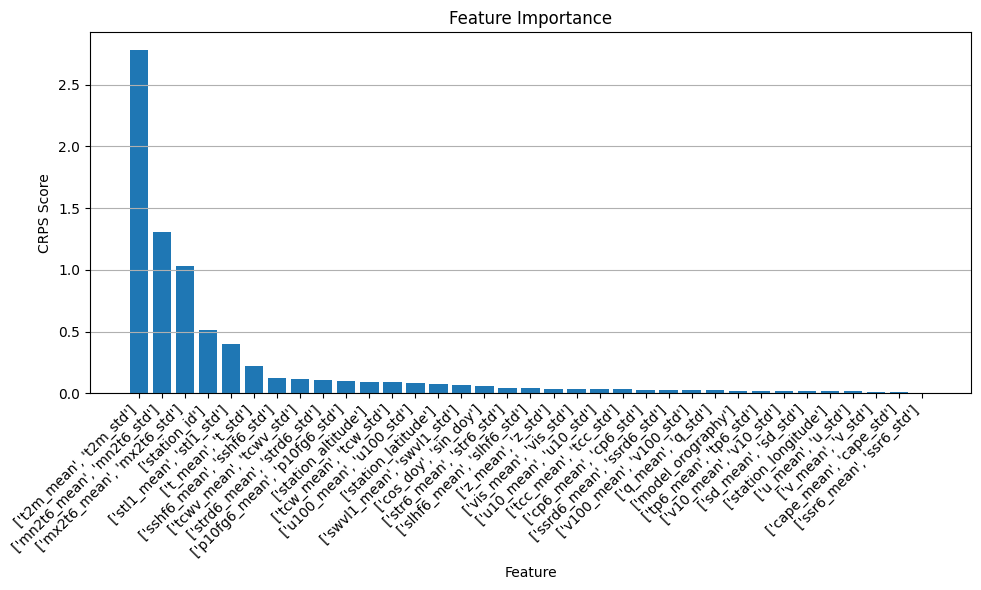

In [29]:
sorted_pi = df_combined.sort_values(by='CRPS_mean', ascending=False)
# sorted_pi['Feature'] = sorted_pi['Feature'].apply(lambda x: '-'.join(x) if isinstance(x, list) else str(x))
crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])
print(crps_value)
sorted_pi['Relative'] = (sorted_pi['CRPS_mean'] - crps_value) / crps_value
plt.figure(figsize=(10, 6))
plt.bar(sorted_pi['Feature'], sorted_pi['Relative'])

plt.xlabel('Feature')
plt.ylabel('CRPS Score')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x labels so they don't overlap
plt.grid(axis='y')  # Horizontal grid lines
plt.tight_layout()  # Fit everything nicely
plt.show()

### Permutation Importance for DRN

In [10]:
JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, drn=True)
print(JSONPATH, SAVEPATH, RESULTPATH)

/home/ltchen/gnnpp/leas_trained_models/drn_24h/params.json /home/ltchen/gnnpp/leas_trained_models/drn_24h/models /home/ltchen/gnnpp/leas_trained_models/drn_24h


In [8]:
train, test_rf, test_f = load_drn_data(leadtime)

CONFIG_FOLDER = os.path.join(DIRECTORY, f"trained_models/drn_{leadtime}")
JSONPATH, SAVEPATH, RESULT = get_json_save_result_paths(leadtime=leadtime, drn=True)

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
print(args_dict)
config = args_dict
batch_size = config['batch_size']
hidden_channels = config['hidden_channels']
lr = config['lr']
max_epochs = config['max_epochs']
embed_dim = 20
in_channels = train[0].shape[1] + embed_dim - 1 # 65 + 20 - 1

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f
[INFO] Normalizing features...
[INFO] Loading /home/ltchen/gnnpp/trained_models/drn_24h/params.json
{'leadtime': '24h', 'batch_size': 4096, 'lr': 0.01, 'hidden_channels': [256], 'max_epochs': 26, 'only_summary': 'True'}


In [32]:
all_feature_names, feature_list = get_feature_list(test_f[0])

NameError: name 'test_f' is not defined

In [43]:
rows = []

if data_type == "f":
    test = test_f
else:
    test = test_rf

y_scaler = StandardScaler(with_std=False)
y_scaler = y_scaler.fit(train[1][["t2m"]])

times_to_shuff = 3

for f_list in feature_list:
    feature_idx = [i for i, value in enumerate(all_feature_names) if value in f_list]
    x = test[0].to_numpy()
    xs_shuffled = shuffle_drn_features(xs=x, feature_permute_idx=feature_idx)
    shuffled_dataset = TensorDataset(torch.Tensor(xs_shuffled), torch.Tensor(y_scaler.transform(test[1][["t2m"]])))

    bs = config['batch_size']

    shuffled_test_loader = DataLoader(shuffled_dataset, batch_size=bs, shuffle=False)

    preds_list = []
    # for run_no in range(0, 10):
    run_no = 0
    drn = load_drn_model(
        f"{SAVEPATH}/drn_{leadtime}_train_run{run_no}.ckpt",
        embed_dim,
        in_channels,
        config['hidden_channels'])
    # print(f"{SAVEPATH}/drn_{leadtime}_train_run{run_no}.ckpt")
    # print(f_list)
    # batch = next(iter(shuffled_test_loader))
    # batch = batch.to("cuda")
    # drn.to("cuda")
    # drn.forward(batch)
    drn.eval()
    trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=False)
    preds = trainer.predict(model=drn, dataloaders=[shuffled_test_loader])
    # print(f"\033[91m len(preds):{len(preds)} \033[0m")
    preds = torch.cat(preds, dim=0)
    preds[:, 0] = torch.Tensor(y_scaler.inverse_transform(preds[:, 0].view(-1, 1))).flatten() # 273
    # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
    preds_list.append(preds)
    ####
    if data_type == "f":
        targets = test_f[1]
    else:
        targets = test_rf[1]
    targets = torch.tensor(targets.t2m.values) # - 273.15
    # print(f"targets: {targets}")
    # print(f"preds_list: {preds_list}")
    # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
    stacked = torch.stack(preds_list)
    final_preds = torch.mean(stacked, dim=0)

    res = drn.loss_fn.crps(final_preds, targets) # mean
    # print(f"res: {res}´")
    score = res.item()
    # print(f"score: {score}")

    rows.append({
        'Feature': f_list,
        'CRPS': score,
    })
    # print(len(rows))
stored_pi = pd.DataFrame(rows)
print(stored_pi)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 1)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 1)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 1)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 1)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 1)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


(86742, 2)


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


                      Feature      CRPS
0                [station_id]  0.935694
1           [model_orography]  1.009556
2          [station_altitude]  1.098143
3          [station_latitude]  0.669884
4         [station_longitude]  0.640764
5       [cape_mean, cape_std]  0.632785
6           [sd_mean, sd_std]  0.636631
7       [stl1_mean, stl1_std]  0.891766
8     [swvl1_mean, swvl1_std]  0.701725
9         [t2m_mean, t2m_std]  2.299149
10        [tcc_mean, tcc_std]  0.646556
11        [tcw_mean, tcw_std]  0.712163
12      [tcwv_mean, tcwv_std]  0.712413
13        [u10_mean, u10_std]  0.680846
14      [u100_mean, u100_std]  0.720173
15        [v10_mean, v10_std]  0.658678
16      [v100_mean, v100_std]  0.668479
17        [vis_mean, vis_std]  0.645205
18        [cp6_mean, cp6_std]  0.642546
19    [mn2t6_mean, mn2t6_std]  1.219500
20    [mx2t6_mean, mx2t6_std]  1.343465
21  [p10fg6_mean, p10fg6_std]  0.709941
22    [slhf6_mean, slhf6_std]  0.656437
23    [sshf6_mean, sshf6_std]  0.705909


In [20]:
RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/drn_{leadtime}")
print(RESULTPATH)


/home/ltchen/gnnpp/leas_trained_models/drn_24h


In [44]:
stored_pi.to_csv(os.path.join(RESULTPATH, f'leas_permutation_importance_{data_type}.csv'), index=False)

In [45]:
sorted_stored_pi = stored_pi.sort_values(by='CRPS', ascending=False)
sorted_stored_pi['Feature'] = sorted_stored_pi['Feature'].apply(
    lambda x: '-'.join(x) if isinstance(x, list) else str(x))
crps_value = float(
    [line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(
        ':')[1])
print(crps_value)
sorted_stored_pi['Relative'] = (sorted_stored_pi['CRPS'] - crps_value) / crps_value
sorted_stored_pi

0.6057152649441765


,Feature,CRPS,Relative
9,t2m_mean-t2m_std,2.299149,2.795759
20,mx2t6_mean-mx2t6_std,1.343465,1.217981
19,mn2t6_mean-mn2t6_std,1.219500,1.013323
2,station_altitude,1.098143,0.812970
1,model_orography,1.009556,0.666717
33,t_mean-t_std,0.955911,0.578152
0,station_id,0.935694,0.544775
7,stl1_mean-stl1_std,0.891766,0.472252
14,u100_mean-u100_std,0.720173,0.188964
12,tcwv_mean-tcwv_std,0.712413,0.176152


In [54]:
normalized_df = sorted_stored_pi['Relative'] / sorted_stored_pi['Relative'].sum()
normalized_df

9     0.257131
20    0.112020
19    0.093197
2     0.074770
1     0.061319
33    0.053174
0     0.050104
7     0.043434
14    0.017379
12    0.016201
11    0.016163
21    0.015826
23    0.015213
8     0.014578
27    0.014207
13    0.011408
34    0.011313
29    0.010081
3     0.009743
16    0.009530
25    0.008049
15    0.008042
26    0.007792
22    0.007702
28    0.006922
31    0.006259
10    0.006201
17    0.005996
24    0.005759
18    0.005592
30    0.005509
4     0.005322
32    0.005258
6     0.004694
5     0.004110
Name: Relative, dtype: float64

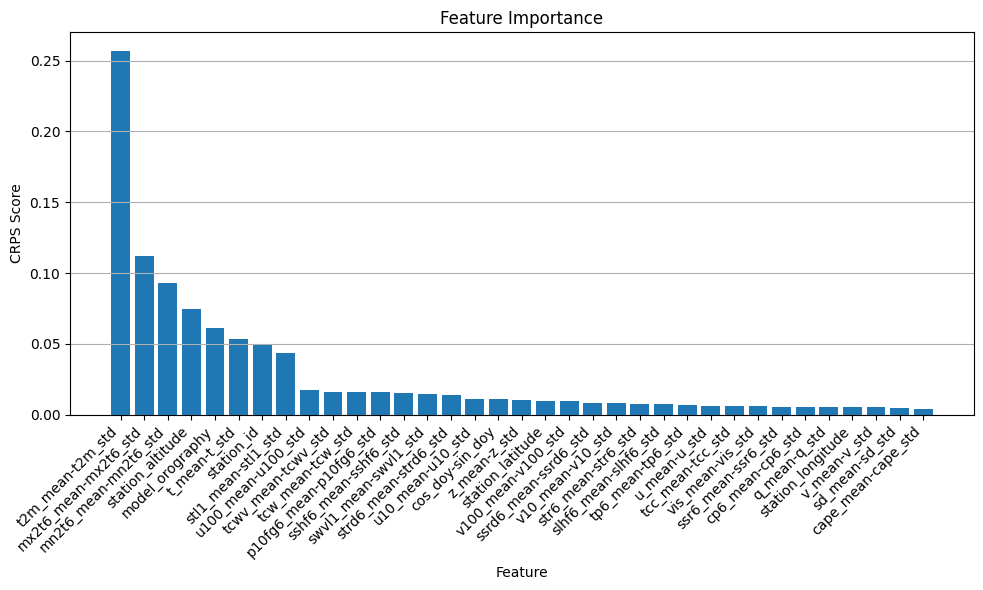

In [55]:
# df = sorted_stored_pi['Relative'].apply(normalize_category)  #.reset_index().drop(columns=["level_1"])
plt.figure(figsize=(10, 6))
plt.bar(sorted_stored_pi['Feature'], normalized_df)

plt.xlabel('Feature')
plt.ylabel('CRPS Score')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x labels so they don't overlap
plt.grid(axis='y')  # Horizontal grid lines
plt.tight_layout()  # Fit everything nicely
plt.show()

## One run permutations

In [10]:
## PROJECTNAME = "gnn_run7"
# FILENAME = graph_name + "_run_" + leadtime
TRAINNAME = f"{graph_name}_{leadtime}_train_run1"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
# RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/best_{leadtime}/best_{leadtime}_{graph_name}")
RESULTPATH = JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}")
print(RESULTPATH)

multigraph = Multigraph.load_from_checkpoint(
    CKPT_PATH,
    num_nodes=num_nodes,
    embedding_dim=emb_dim,
    edge_dim=edge_dim,
    in_channels=in_channels,
    hidden_channels_gnn=config['gnn_hidden'],
    out_channels_gnn=config['gnn_hidden'],
    num_layers_gnn=config['gnn_layers'],
    heads=config['heads'],
    hidden_channels_deepset=config['gnn_hidden'],
    optimizer_class=AdamW,
    optimizer_params=dict(lr=config['lr']),
)
# torch_geometric.compile(multigraph)
multigraph.eval()
batch = next(iter(train_loader))
batch = batch.to("cuda")
multigraph.to("cuda")
multigraph.forward(batch)
trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=True)
# trainer = L.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g1_72h


In [11]:
data_list = ["f", "rf"]

for data, tl in zip(data_list, test_loader):
    preds_list = []
    preds = trainer.predict(model=multigraph, dataloaders=[tl]) # 92 x 976 x 2 forecasts with mu and sigma of 122 stations
    #print(preds[0].shape) # 960 (8*120), 2
    print(preds)
    preds = torch.cat(preds, dim=0)
    preds_list.append(preds)

    targets = dataframes[f"test_{data}"][1]
    print(targets)
    targets = torch.tensor(targets.t2m.values) - 273.15
    print(targets)
    stacked = torch.stack(preds_list)
    final_preds = torch.mean(stacked, dim=0)

    res = multigraph.loss_fn.crps(final_preds, targets)
    print("#############################################")
    print("#############################################")
    print(f"final crps: {res.item()}")
    print("#############################################")
    print("#############################################")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 92/92 [00:00<00:00, 132.59it/s]
[tensor([[ 7.9224,  0.9342],
        [ 7.1080,  1.1906],
        [ 8.0477,  0.9263],
        ...,
        [-0.4131,  1.5746],
        [-5.6300,  2.0037],
        [-6.7494,  2.2484]]), tensor([[  6.5155,   0.8798],
        [  6.3692,   0.9824],
        [  6.7003,   0.8821],
        ...,
        [ -8.7601,   2.2038],
        [-15.3016,   3.2034],
        [-17.2993,   3.3023]]), tensor([[ 1.8194,  1.9722],
        [ 0.8307,  1.8743],
        [ 2.5461,  1.9943],
        ...,
        [-3.7036,  2.2299],
        [-5.2576,  2.2957],
        [-9.0599,  2.7975]]), tensor([[ 4.0108,  1.3932],
        [ 5.2866,  1.5720],
        [ 4.0670,  1.3137],
        ...,
        [ 3.8677,  1.8965],
        [-0.7152,  1.3376],
        [-1.1569,  1.3606]]), tensor([[ 4.1334,  1.4316],
        [ 5.5861,  1.4486],
        [ 4.3546,  1.4205],
        ...,
        [ 1.4213,  2.1568],
        [-4.4796,  1.8232],
        [-6.7489,  2.1910]])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


#############################################
#############################################
final crps: 0.8251113284911652
#############################################
#############################################


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 92/92 [00:00<00:00, 137.30it/s]
[tensor([[ 8.0977,  1.2511],
        [ 8.7143,  1.3631],
        [ 8.0380,  1.2631],
        ...,
        [ 2.0395,  1.4014],
        [-3.1663,  1.4726],
        [-3.6578,  1.6211]]), tensor([[-0.5672,  1.6572],
        [-0.7692,  1.4809],
        [-0.3613,  1.6519],
        ...,
        [ 1.7501,  1.3004],
        [-3.3053,  1.4862],
        [-4.2185,  1.6658]]), tensor([[  2.1475,   2.1411],
        [  1.3486,   2.0887],
        [  2.8005,   2.1302],
        ...,
        [ -6.4355,   2.2686],
        [-13.9317,   3.4983],
        [-15.3510,   3.6329]]), tensor([[  2.5454,   2.1350],
        [  2.6853,   2.1171],
        [  2.9432,   2.1161],
        ...,
        [ -2.7184,   1.9857],
        [-11.3673,   3.1142],
        [-14.2617,   3.5552]]), tensor([[1.4959, 1.1634],
        [0.9828, 1.4838],
        [1.5490, 1.1621],
        ...,
        [7.0416, 2.6598],
        [2.2383, 1.8575],
        [0.9972, 1.9717]])

In [12]:
g_test_rf[0]

Data(x=[120, 65], edge_index=[2, 342], edge_attr=[342, 1], y=[120], timestamp=2014-01-01 00:00:00, n_idx=[120])

In [85]:
curr_data = g_test_rf[0].clone()
# curr_data.x[target_station_id] = feature_vec

device = next(multigraph.parameters()).device
curr_data = curr_data.to(device)

curr_data.batch = torch.zeros(curr_data.num_nodes, dtype=torch.long, device=device)
curr_data.n_idx = torch.tensor(range(curr_data.num_nodes), dtype=torch.long, device=device)
print(curr_data)
# dl = DataLoader(curr_data, batch_size=1, shuffle=False)
multigraph(curr_data)
# trainer.predict(model=multigraph, dataloaders=[dl])

Data(x=[120, 65], edge_index=[2, 342], edge_attr=[342, 1], y=[120], timestamp=2014-01-01 00:00:00, n_idx=[120], batch=[120])


tensor([[ 7.1465,  0.6699],
        [ 7.6936,  0.6457],
        [ 7.2608,  0.6095],
        [ 6.3364,  0.5989],
        [ 7.7216,  0.6688],
        [ 6.2587,  0.6158],
        [ 7.3415,  0.6308],
        [ 6.4931,  0.6102],
        [ 6.5880,  0.6474],
        [ 7.2138,  0.7601],
        [ 6.7266,  0.6100],
        [ 7.1717,  0.7221],
        [ 6.4969,  0.6943],
        [ 6.2765,  0.6747],
        [ 6.8768,  0.8028],
        [ 5.7185,  0.6663],
        [ 6.9109,  0.7836],
        [ 8.2398,  0.5849],
        [ 8.4153,  0.6402],
        [ 8.6706,  0.6281],
        [ 7.9464,  0.5886],
        [ 8.8080,  0.6590],
        [ 8.3614,  0.6292],
        [ 7.7939,  0.6500],
        [ 8.0009,  0.6787],
        [ 7.8578,  0.6700],
        [ 8.1425,  0.6829],
        [ 7.7111,  0.7540],
        [ 8.3623,  0.6900],
        [ 7.0550,  0.8316],
        [ 6.3784,  0.8723],
        [ 4.4574,  0.6715],
        [ 5.0553,  0.8581],
        [ 4.6252,  0.6846],
        [ 5.8417,  0.7021],
        [ 5.5145,  0

In [ ]:
# node_mask = (curr_data.n_idx + curr_data.batch * multigraph.num_nodes) == target_station_id
# target_output = output[node_mask][0, 0]

### Other tests for permutation importance

In [ ]:
# load t2m_labels, mu, sigma from csv
# get feature_names and shuffle features
# create graph with shuffled features
# load into test_loader
# evaluate ensemble by calcualting crps
# save results in csv
# Kann ich permutation importance auch auf edge features anwenden? => edge attributes shufflen?

In [86]:
#  = dataframes['test_f'][0].columns.tolist() # - ['time', 'number']
feature_names = [f for f in dataframes['test_f'][0].columns.tolist() if f not in ['time', 'number']] # dropped time and number: len - 65
feature_names
# len(feature_names)

['station_id',
 'model_orography',
 'station_altitude',
 'station_latitude',
 'station_longitude',
 'cape_mean',
 'cape_std',
 'sd_mean',
 'sd_std',
 'stl1_mean',
 'stl1_std',
 'swvl1_mean',
 'swvl1_std',
 't2m_mean',
 't2m_std',
 'tcc_mean',
 'tcc_std',
 'tcw_mean',
 'tcw_std',
 'tcwv_mean',
 'tcwv_std',
 'u10_mean',
 'u10_std',
 'u100_mean',
 'u100_std',
 'v10_mean',
 'v10_std',
 'v100_mean',
 'v100_std',
 'vis_mean',
 'vis_std',
 'cp6_mean',
 'cp6_std',
 'mn2t6_mean',
 'mn2t6_std',
 'mx2t6_mean',
 'mx2t6_std',
 'p10fg6_mean',
 'p10fg6_std',
 'slhf6_mean',
 'slhf6_std',
 'sshf6_mean',
 'sshf6_std',
 'ssr6_mean',
 'ssr6_std',
 'ssrd6_mean',
 'ssrd6_std',
 'str6_mean',
 'str6_std',
 'strd6_mean',
 'strd6_std',
 'tp6_mean',
 'tp6_std',
 'z_mean',
 'z_std',
 'q_mean',
 'q_std',
 'u_mean',
 'u_std',
 'v_mean',
 'v_std',
 't_mean',
 't_std',
 'cos_doy',
 'sin_doy']

In [74]:
graphs1_test_f[0].x[:,63]
graphs1_test_f[100].x[:,63] # alle am gleichen Tag, daher alle gleich

tensor([-0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671, -0.1671,
        -0.1671, -0.1671, -0.1671, -0.16

In [20]:
torch.Tensor(dataframes[f"test_{data_type}"][1]["t2m"]).unsqueeze(1).shape

torch.Size([87600, 1])

In [15]:
# try for one feature first!!
graphs_test = g_test_f
feature_idx = [i for i, value in enumerate(all_feature_names) if value in ['station_altitude']]

xs = [g.x for g in graphs_test]

xs = torch.stack(xs)

xs_permuted = xs[..., feature_idx]
xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
graphs_test_shuffled = []


i = 0
for graph, shuffled_feature in zip(graphs_test, xs_shuffled):
    graph_copy = copy.deepcopy(graph)
    graph_copy.x = shuffled_feature
    graphs_test_shuffled.append(graph_copy) # len 732

bs = 1 # if data_type == "rf" else 5
shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)

preds = trainer.predict(model=multigraph, dataloaders=[shuffled_test_loader])

# if data_type == "f":
#     preds = [prediction.reshape(5, 122, 2).mean(axis=0) for prediction in preds]
targets = dataframes[f"test_{data_type}"][1]
targets = torch.tensor(targets.t2m.values) - 273.15

print(f"\033[91m len(preds):{len(preds)} \033[0m")
preds = torch.cat(preds, dim=0)
print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
res = multigraph.loss_fn.crps(preds, targets)
score = res.item()

print(f"########### targets ############\n{targets}")
print(f"########### preds ############\n{preds}")
print(f"########### RES ############\n{res}")
print(f"########### SCORE ############\n{score}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 730/730 [00:04<00:00, 179.96it/s]
 len(preds):730 
 Preds.shape:torch.Size([87600, 2]) 
 Targets.shape:torch.Size([87600]) 
########### targets ############
tensor([ 7.9000,  7.4000,  8.2000,  ..., -0.7000, -8.6000, -8.4000],
       dtype=torch.float64)
########### preds ############
tensor([[ 7.7144,  0.9273],
        [ 6.3389,  1.1421],
        [ 7.7361,  0.9177],
        ...,
        [-3.0519,  1.2267],
        [-9.0380,  1.9254],
        [-9.6367,  2.0368]])
########### RES ############
0.88336935449408
########### SCORE ############
0.88336935449408


In [88]:
values = feature_names
grouped = []
i = 0
while i < len(values):
    if values[i] == 'cos_doy':
        if i + 1 < len(values) and 'sin_doy' in values[i+1]:
            grouped.append([values[i], values[i+1]])
            i += 2
        else:
            grouped.append([values[i]])
            i += 1
    elif i + 1 < len(values) and values[i+1] == values[i].replace('mean', 'std'):
        grouped.append([values[i], values[i+1]])
        i += 2
    else:
        grouped.append([values[i]])
        i += 1

print(grouped)

[['station_id'], ['model_orography'], ['station_altitude'], ['station_latitude'], ['station_longitude'], ['cape_mean', 'cape_std'], ['sd_mean', 'sd_std'], ['stl1_mean', 'stl1_std'], ['swvl1_mean', 'swvl1_std'], ['t2m_mean', 't2m_std'], ['tcc_mean', 'tcc_std'], ['tcw_mean', 'tcw_std'], ['tcwv_mean', 'tcwv_std'], ['u10_mean', 'u10_std'], ['u100_mean', 'u100_std'], ['v10_mean', 'v10_std'], ['v100_mean', 'v100_std'], ['vis_mean', 'vis_std'], ['cp6_mean', 'cp6_std'], ['mn2t6_mean', 'mn2t6_std'], ['mx2t6_mean', 'mx2t6_std'], ['p10fg6_mean', 'p10fg6_std'], ['slhf6_mean', 'slhf6_std'], ['sshf6_mean', 'sshf6_std'], ['ssr6_mean', 'ssr6_std'], ['ssrd6_mean', 'ssrd6_std'], ['str6_mean', 'str6_std'], ['strd6_mean', 'strd6_std'], ['tp6_mean', 'tp6_std'], ['z_mean', 'z_std'], ['q_mean', 'q_std'], ['u_mean', 'u_std'], ['v_mean', 'v_std'], ['t_mean', 't_std'], ['cos_doy', 'sin_doy']]


In [89]:
# try for all features (in pairs) - mean and std
feature_list = grouped
graphs_test = graphs1_test_f
data_type = "f"

rows = []

for f_list in feature_list:
    feature_idx = [i for i, value in enumerate(feature_names) if value in f_list]
    xs = [g.x for g in graphs_test]
    xs = torch.stack(xs)

    xs_permuted = xs[..., feature_idx]
    xs_shuffled = shuffle_features(xs=xs, feature_permute_idx=feature_idx)
    graphs_test_shuffled = []


    i = 0
    for graph, shuffled_feature in zip(graphs_test, xs_shuffled):
        graph_copy = copy.deepcopy(graph)
        graph_copy.x = shuffled_feature
        graphs_test_shuffled.append(graph_copy) # len 732

    bs = 1
    shuffled_test_loader = DataLoader(graphs_test_shuffled, batch_size=bs, shuffle=False)

    preds = trainer.predict(model=multigraph, dataloaders=[shuffled_test_loader])
    targets = dataframes[f"test_{data_type}"][1]
    targets = torch.tensor(targets.t2m.values) - 273.15

    # print(f"\033[91m len(preds):{len(preds)} \033[0m")
    preds = torch.cat(preds, dim=0)
    # print(f"\033[91m Preds.shape:{preds.shape} \033[0m")
    # print(f"\033[91m Targets.shape:{targets.shape} \033[0m")
    res = multigraph.loss_fn.crps(preds, targets)
    score = res.item()

    rows.append({
        'Feature': f_list,
        'CRPS': score,
    })
stored_pi = pd.DataFrame(rows)
print(stored_pi)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 218.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 206.94it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 198.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 226.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 203.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 197.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 196.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 194.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 185.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 191.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 201.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 198.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 194.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 190.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 198.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 207.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 217.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 207.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 211.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 198.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 209.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 212.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 193.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 208.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 210.55it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 205.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 201.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 195.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 211.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 185.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 231.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 206.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 231.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 229.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 730/730 [00:03<00:00, 195.65it/s]
                      Feature      CRPS
0                [station_id]  1.071133
1           [model_orography]  0.651872
2          [station_altitude]  0.757561
3          [station_latitude]  0.658397
4         [station_longitude]  0.639676
5       [cape_mean, cape_std]  0.633485
6           [sd_mean, sd_std]  0.642529
7       [stl1_mean, stl1_std]  0.869611
8     [swvl1_mean, swvl1_std]  0.679371
9         [t2m_mean, t2m_std]  2.311890
10        [tcc_mean, tcc_std]  0.641643
11        [tcw_mean, tcw_std]  0.688862
12      [tcwv_mean, tcwv_std]  0.697875
13        [u10_mean, u10_std]  0.643289
14      [u100_mean, u100_std]  0.672286
15        [v10_mean, v10_std]  0.636841
16      [v100_mean, v100_std]  0.643886
17        [vis_mean, vis_std]  0.645943
18        [cp6_mean, cp6_std]  0.644046
19    [mn2t6_mean, mn2t6_std]  1.408243
20    [mx2t6_mean, mx2t6_std]  1.281196
21  [p10fg6_mean, p10fg6_std]  0.695144
22  

In [90]:
stored_pi.to_csv(os.path.join(RESULTPATH, f'leas_permutation_importance_{data_type}.csv'), index=False)
crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])


In [91]:
print(crps_value)

0.6149606924107296


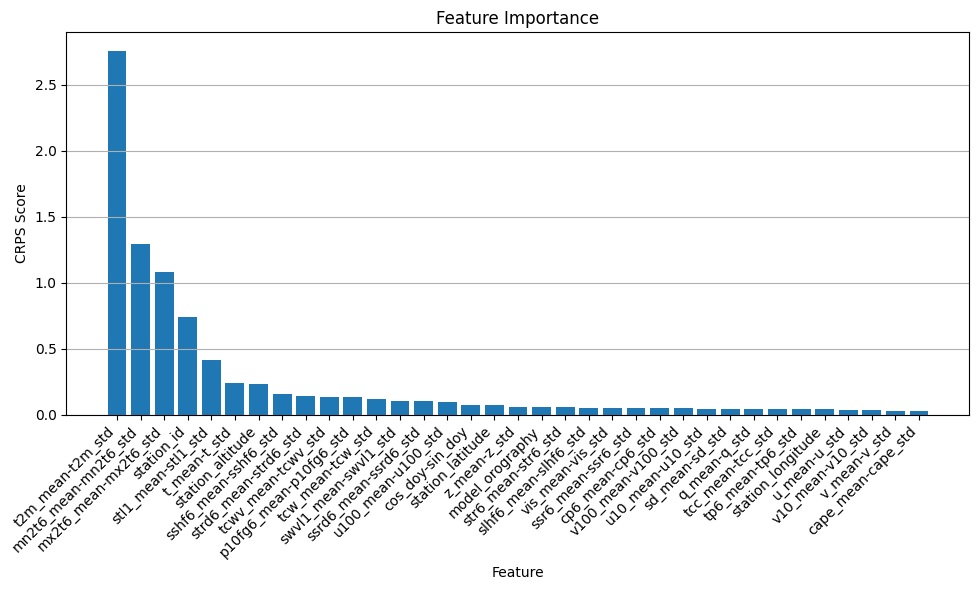

In [92]:
sorted_stored_pi = stored_pi.sort_values(by='CRPS', ascending=False)
sorted_stored_pi['Feature'] = sorted_stored_pi['Feature'].apply(lambda x: '-'.join(x) if isinstance(x, list) else str(x))
sorted_stored_pi['Relative'] = (sorted_stored_pi['CRPS'] - crps_value)/ crps_value
plt.figure(figsize=(10, 6))
plt.bar(sorted_stored_pi['Feature'], sorted_stored_pi['Relative'])

plt.xlabel('Feature')
plt.ylabel('CRPS Score')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x labels so they don't overlap
plt.grid(axis='y')  # Horizontal grid lines
plt.tight_layout()  # Fit everything nicely
plt.show()

## Shapley Values
take only predicted mu for this

In [7]:
_, graphs1_tests_shapley = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['valid'], dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo"], edges=[("geo", 100)], sum_stats = True)
_, graphs1_test_rf_shapley, graphs1_test_f_shapley = graphs1_tests_shapley

[INFO] Normalizing features...
fit_transform
transform 1
transform 2
transform 3


100%|██████████| 730/730 [00:02<00:00, 260.13it/s]


In [36]:
graphs1_test_rf[0].x[0].shape # 65 features
graphs1_test_rf[0].y[0]

torch.Size([])

In [40]:
# target node features in x
target_station_id = 0
target_station_features = []
target_station_y = []
for i in range(0, len(graphs1_test_rf)):
    target_station_features.append(graphs1_test_rf[i].x[0].cpu()) # x[0] for
    target_station_y.append(graphs1_test_rf[i].y[0].cpu())
len(target_station_features)
# list of
# first row of first time step

732

In [41]:
len(target_station_y)

732

In [42]:
target_station_features = torch.stack(target_station_features)
target_station_y = torch.stack(target_station_y)
target_station_features_np = target_station_features.numpy()
target_station_y_np = target_station_y.numpy()
target_station_features_np.shape
target_station_y_np.shape

(732,)

In [12]:
# prediction wrapper, input: features of station0, output: prediction of station0
def wrapper(s0_features):
    if isinstance(s0_features, np.ndarray):
        s0_features = torch.tensor(s0_features, dtype=torch.float32, device=next(multigraph.parameters()).device)

    results = []
    for i, feature_vec in enumerate(s0_features):
        template_idx = min(i, len(graphs1_test_rf) - 1)
        curr_data = graphs1_test_rf[template_idx].clone()
        curr_data.x[target_station_id] = feature_vec

        device = next(multigraph.parameters()).device
        curr_data = curr_data.to(device)

        curr_data.batch = torch.zeros(curr_data.num_nodes, dtype=torch.long, device=device)
        curr_data.n_idx = torch.tensor(range(curr_data.num_nodes), dtype=torch.long, device=device)

        with torch.no_grad():
            output = multigraph(curr_data)
        # print(output)

        if hasattr(curr_data, 'batch'):
            # print(output.shape)
            node_mask = (curr_data.n_idx + curr_data.batch * multigraph.num_nodes) == target_station_id
            # print(node_mask.shape)
            target_output = output[node_mask][0, 0].cpu().numpy()  # Take mean (first value)
            # print(target_output)
        else:
            target_output = output[0, 0].cpu().numpy()  # Take mean (first value)

        results.append(target_output)

    return np.array(results).reshape(-1, 1)

In [44]:
# background data establishment
n_background = 20 # 200
np.random.seed(0)
background_indices = np.random.choice(len(target_station_features_np), n_background, replace=False)
background_data = target_station_features_np[background_indices]

In [45]:
# SHAP explainer initialization
explainer = shap.KernelExplainer(wrapper, background_data)

In [46]:
n_samples = 50

sample_indices = np.random.choice(len(target_station_features_np), n_samples, replace=False)
sample_features = target_station_features_np[sample_indices]
sample_y = np.random.choice(len(target_station_y_np), n_samples, replace=False)
sample_features.shape
sample_y.shape

(50,)

In [90]:
shap_values = explainer.shap_values(sample_features) # gleiches sample?


100%|██████████| 50/50 [10:14:46<00:00, 737.72s/it]


In [98]:
if isinstance(shap_values, list):
    print(shap_values[0])
print(type(shap_values))

np.save(os.path.join('shap_values1.npy'), shap_values)

<class 'numpy.ndarray'>


In [16]:
shap_values = np.load(os.path.join('shap_values1.npy'))

In [47]:
target_station_y_np

array([ 6.200012 ,  5.5      ,  7.       ,  9.300018 ,  6.3000183,
       -2.100006 ,  3.899994 ,  1.3000183, -1.6000061,  5.200012 ,
       -0.7999878,  9.800018 ,  4.399994 ,  6.399994 ,  4.100006 ,
        4.3000183, -0.7999878,  0.6000061,  0.7000122,  6.8000183,
        7.399994 ,  1.1000061,  4.100006 ,  1.2000122,  6.399994 ,
       -3.1999817,  2.899994 ,  1.3000183,  5.5      ,  5.700012 ,
        3.600006 ,  3.100006 ,  1.2000122,  6.       ,  1.8999939,
        8.5      , -0.1000061,  4.8000183,  7.100006 ,  4.399994 ,
        6.200012 ,  3.3000183,  5.       ,  6.100006 ,  1.3999939,
        6.       ,  3.       ,  8.100006 ,  2.3000183,  3.7000122,
        4.200012 , 11.       , 13.600006 , 10.5      ,  8.600006 ,
        9.300018 ,  7.700012 ,  7.899994 ,  4.3000183,  1.5      ,
        5.600006 ,  6.       ,  1.7000122,  9.5      ,  7.100006 ,
       10.       ,  7.5      , 11.200012 ,  8.899994 ,  9.100006 ,
        8.       , 12.       ,  7.8000183, 12.       , 15.    

In [23]:
# wollte eigentlich checken, ob die shap_values sich auf die sample_y aufsummieren, aber habe das zu spaet erst gemerkt
print(shap_values.shape) # for each sample: shapley value for each feature
print(shap_values.squeeze())
print(np.abs(shap_values).sum(axis=1))
print(np.abs(shap_values).sum(axis=1).shape)


(50, 65, 1)
[[0.         0.         0.         ... 0.25374111 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.20550005]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[2.93813826]
 [1.23596265]
 [3.02489099]
 [2.74130376]
 [2.21052863]
 [3.60653521]
 [1.08532407]
 [1.42170741]
 [3.47409369]
 [3.67586257]
 [3.34512069]
 [2.08819796]
 [2.10727762]
 [3.97309996]
 [2.2398818 ]
 [2.31149604]
 [3.24463107]
 [4.16176535]
 [0.88125111]
 [4.6395991 ]
 [3.21978785]
 [4.66845157]
 [5.44695689]
 [1.76070668]
 [3.34540011]
 [3.2992379 ]
 [2.01088359]
 [2.64337756]
 [1.4071696 ]
 [5.33530833]
 [1.97026898]
 [0.80418803]
 [4.13519027]
 [4.83616759]
 [4.96829059]
 [4.0497544 ]
 [3.99310583]
 [2.6515307 ]
 [2.40572097

In [18]:
feature_names = [f for f in dataframes['test_rf'][0].columns.tolist() if f not in ['time', 'number']]
len(feature_names)

65

#### Feature importance

In [19]:
print(f"SHAP values shape: {shap_values.shape}")
mean_abs_shap = np.abs(shap_values).mean(axis=0) # take the mean over each sample
print(mean_abs_shap.shape)
print(mean_abs_shap)

SHAP values shape: (50, 65, 1)
(65, 1)
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.02223533]
 [0.0081311 ]
 [0.        ]
 [0.        ]
 [0.09426196]
 [0.0520981 ]
 [0.        ]
 [0.        ]
 [0.33947694]
 [0.0179652 ]
 [0.01110122]
 [0.01945724]
 [0.05384147]
 [0.07731461]
 [0.05718793]
 [0.01740057]
 [0.04764975]
 [0.00865194]
 [0.13307245]
 [0.00461199]
 [0.01952981]
 [0.10515127]
 [0.10247894]
 [0.01862689]
 [0.03765988]
 [0.03045391]
 [0.02341638]
 [0.03193408]
 [0.27463847]
 [0.01934765]
 [0.16037076]
 [0.03857278]
 [0.01832333]
 [0.01678621]
 [0.18447111]
 [0.05923871]
 [0.0507707 ]
 [0.07269982]
 [0.02168824]
 [0.00817133]
 [0.02931582]
 [0.03623867]
 [0.08052263]
 [0.02763521]
 [0.09737421]
 [0.05463213]
 [0.02070015]
 [0.04631202]
 [0.0266338 ]
 [0.01090473]
 [0.03986537]
 [0.02488516]
 [0.0330047 ]
 [0.02018018]
 [0.04167744]
 [0.03645431]
 [0.0276471 ]
 [0.0399815 ]
 [0.05131242]
 [0.04698375]]


In [112]:
# Create a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_abs_shap.squeeze()
})
importance_df = importance_df.sort_values('Importance', ascending=False)

In [113]:
importance_df

,Feature,Importance
13,t2m_mean,0.339477
33,mn2t6_mean,0.274638
39,slhf6_mean,0.184471
35,mx2t6_mean,0.160371
23,u100_mean,0.133072
...,...,...
1,model_orography,0.000000
4,station_longitude,0.000000
3,station_latitude,0.000000
2,station_altitude,0.000000



Top 10 most important features for station 0
       Feature  Importance
13    t2m_mean    0.339477
33  mn2t6_mean    0.274638
39  slhf6_mean    0.184471
35  mx2t6_mean    0.160371
23   u100_mean    0.133072
26     v10_std    0.105151
27   v100_mean    0.102479
49  strd6_mean    0.097374
9    stl1_mean    0.094262
47   str6_mean    0.080523


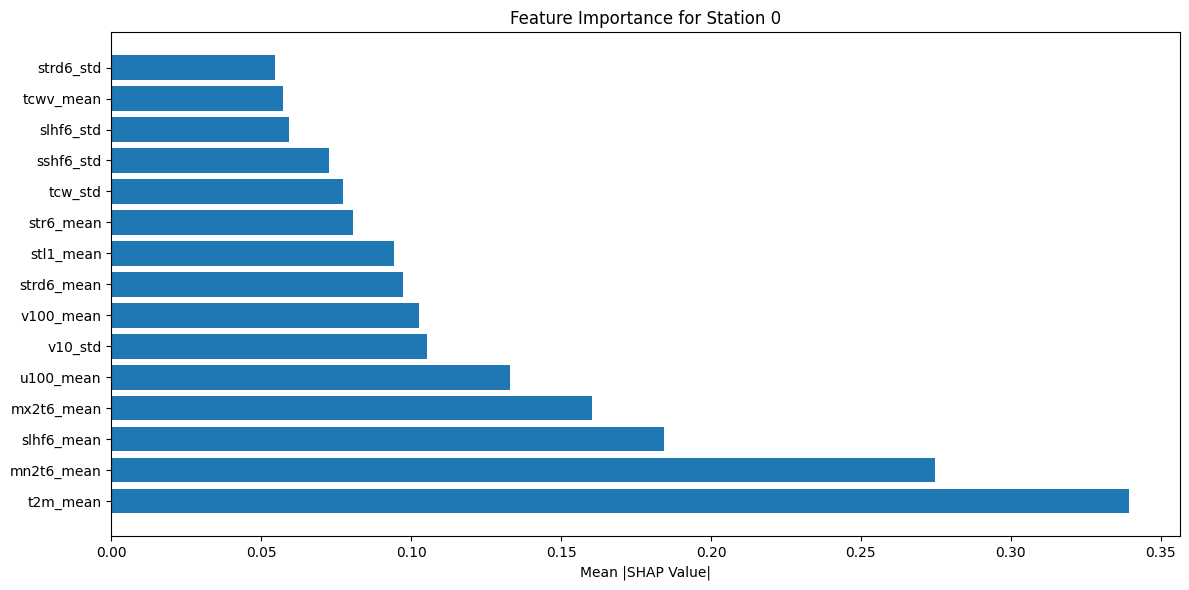

In [114]:
# Display top 10 most important features
print("\nTop 10 most important features for station", target_station_id)
print(importance_df.head(10))

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Mean |SHAP Value|')
plt.title(f'Feature Importance for Station {target_station_id}')
plt.tight_layout()
plt.show()

In [120]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
mean_abs_shap
importance_df[:10]

,Feature,Importance
13,t2m_mean,0.339477
33,mn2t6_mean,0.274638
39,slhf6_mean,0.184471
35,mx2t6_mean,0.160371
23,u100_mean,0.133072
26,v10_std,0.105151
27,v100_mean,0.102479
49,strd6_mean,0.097374
9,stl1_mean,0.094262
47,str6_mean,0.080523


#### Shap plots

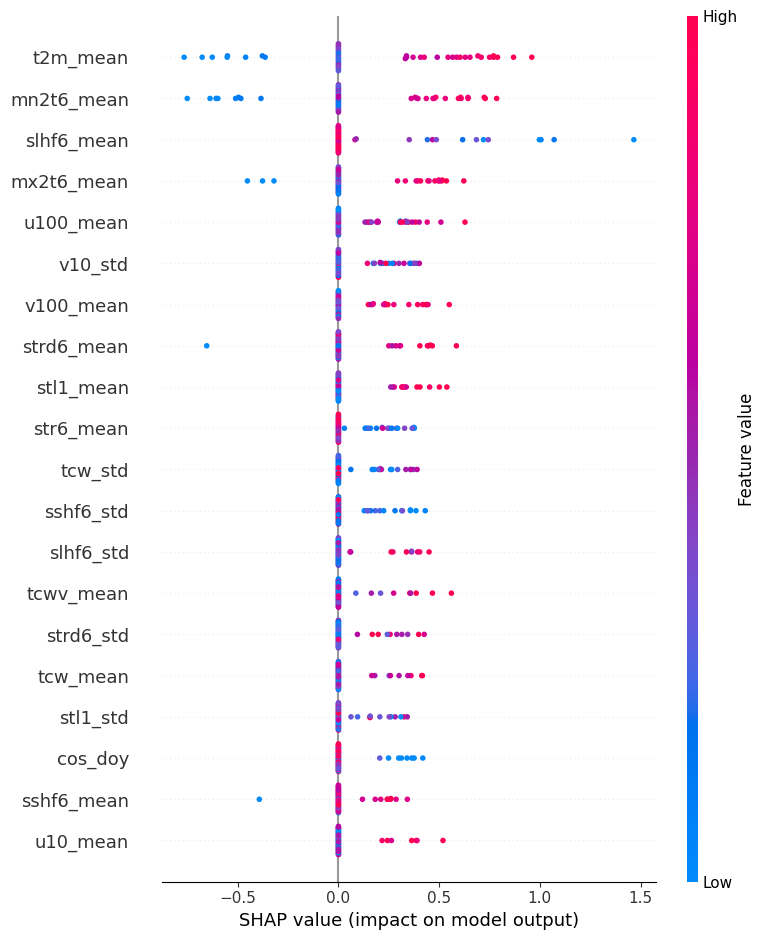

In [123]:
shap.summary_plot(shap_values.squeeze(), sample_features, feature_names)

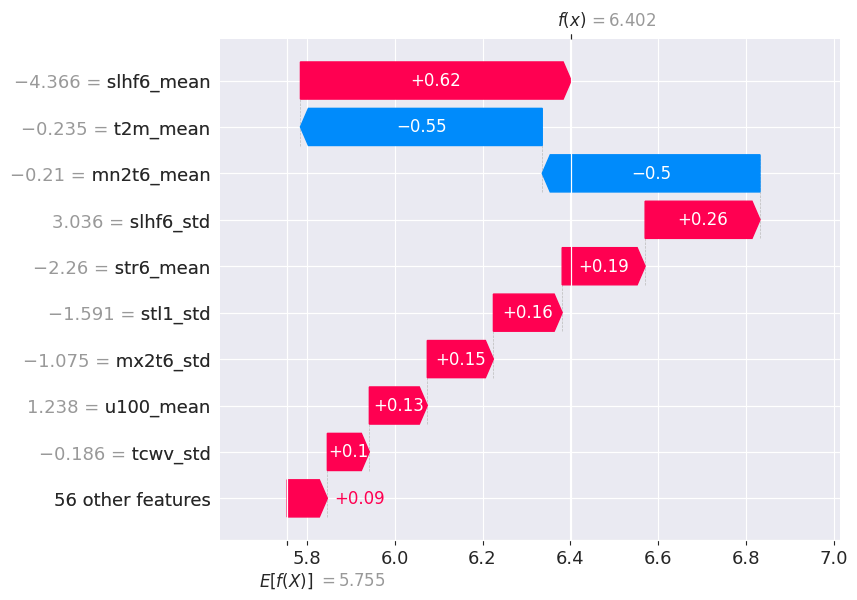

In [72]:
shap_explanation = shap.Explanation(
    values=shap_values[3].squeeze(),
    base_values=explainer.expected_value,
    data=sample_features[3].squeeze(),
    feature_names=feature_names
)
shap.plots.waterfall(shap_explanation)
# check if E(f(x)) is actually 5.755


In [67]:
shap.plots.force(shap_explanation)

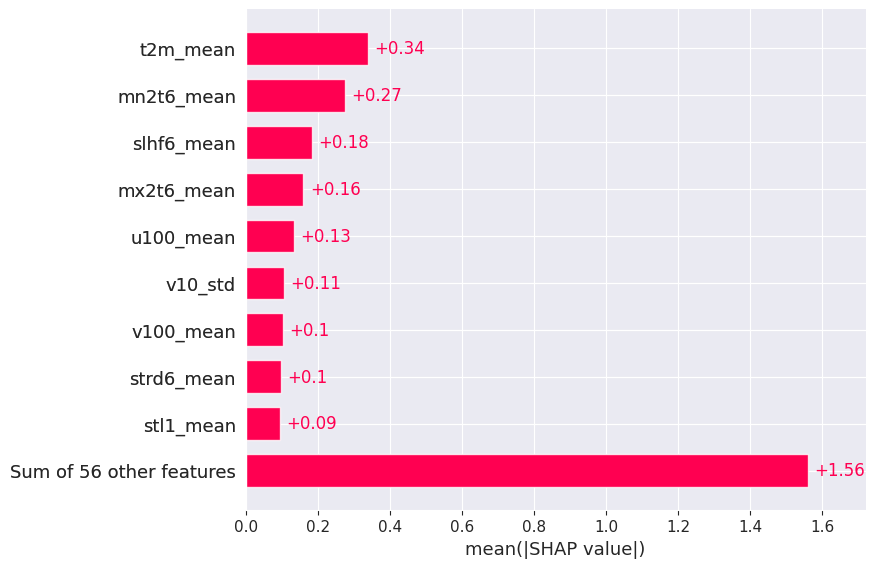

In [74]:
shap_explanation2 = shap.Explanation(
    values=shap_values.squeeze(),
    base_values=explainer.expected_value,
    data=sample_features.squeeze(),
    feature_names=feature_names
)
shap.plots.bar(shap_explanation2)

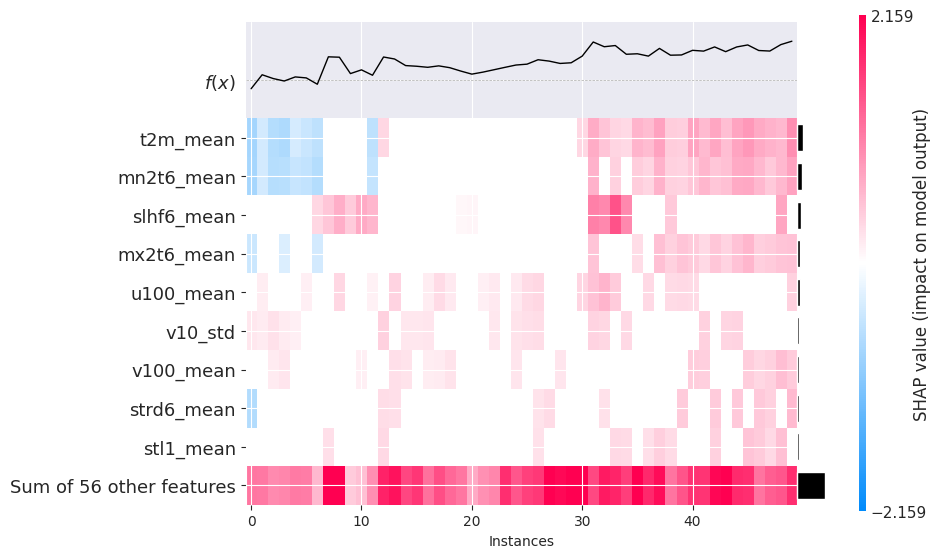

<Axes: xlabel='Instances'>

In [89]:
shap.plots.heatmap(shap_explanation2)

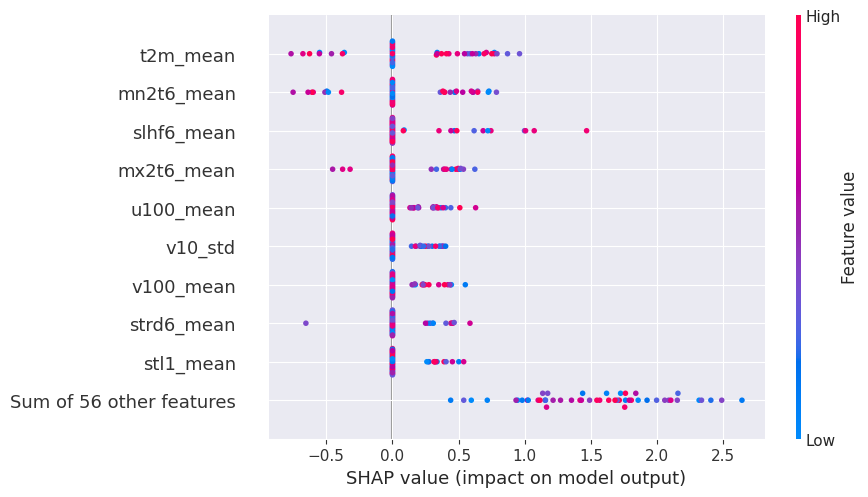

In [75]:
shap.plots.beeswarm(shap_explanation2)

In [68]:
shap.initjs()
shap.f# ???orce_plot(explainer.expected_value, shap_values.squeeze(), sample_features, feature_names=feature_names)

In [79]:
most_important_feature = 't2m_mean'
most_important_idx = feature_names.index(most_important_feature)
most_important_idx

13

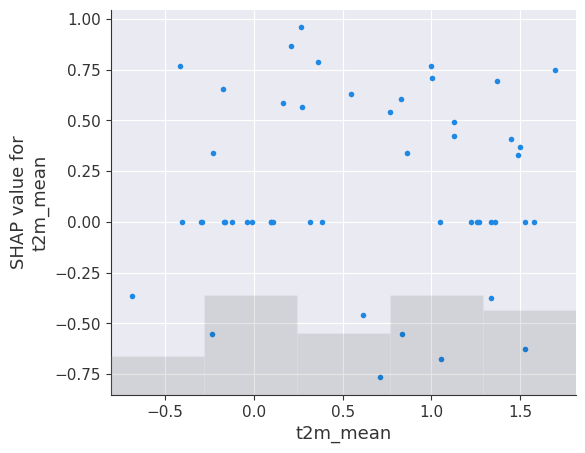

In [87]:
shap.plots.scatter(shap_explanation2[:, most_important_idx])

<Figure size 1000x600 with 0 Axes>

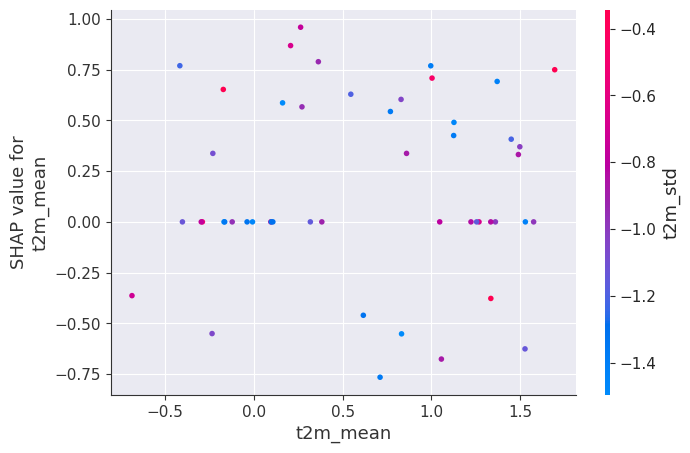

In [83]:
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    most_important_idx,
    shap_values.squeeze(),
    sample_features,
    feature_names=feature_names
)


## GNNExplainer
???

In [142]:
from torch_geometric.explain import GNNExplainer, Explainer

# Initialize the explainer directly on your model
explainer = GNNExplainer(
    model=multigraph,  # Your full model
    epochs=200,
    lr=0.01,
)

# Get a batch from your test loader
batch = next(iter(test_rf_loader))
def explain_node(model, data, node_idx):
    """Explain prediction for a specific node in a graph"""
    gnn_model = GNNPart(model)
    explainer = Explainer(
        model=gnn_model,
        algorithm=GNNExplainer(epochs=200, lr=0.01),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
    )

    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        target=node_idx
    )

    return explanation

In [141]:
node_idx = 0
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx=node_idx,
    x=batch.x,
    edge_index=batch.edge_index,
    edge_attr=batch.edge_attr
)

TypeError: GNNExplainer.forward() missing 1 required positional argument: 'model'

In [ ]:
feature_importance = node_mask.reshape(-1, batch.x.size(1)).mean(dim=0)
print("Feature importance:", feature_importance)

# Visualize the subgraph
ax, G = visualize_subgraph(
    explanation.node_mask,
    explanation.edge_mask,
    explanation.x,
    explanation.edge_index,
    y=batch.y,
    threshold_kwargs=dict(threshold_type='topk', value=10),  # Show top 10 edges
    show=True
)